# Toxic Comments Detection

**This is second part of work with pretrained Bert model implementation.**

Online store "Wikishop" launches a new service. Now users can edit and supplement product descriptions, just like in wiki communities. That is, clients propose their edits and comment on the changes of others. The store needs a tool that will look for toxic comments and submit them for moderation.

The purpose of this work is to build a machine learning iomodel that will detect toxic comments. We have marked data with the text of comments and the target attribute toxic. It is necessary to build a model with the F1 metric value not less than 0.75.

## Prepairing

Installing required libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries and modules

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import transformers as ppb
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

tf.test.gpu_device_name()

'/device:GPU:0'

Setting random state

In [3]:
RS = 23

Downloading the data

*Due to course rules it is not allowed to share the data.*

In [ ]:
# not allowed to show the source of data

Reading the data

In [5]:
data = pd.read_csv('/content/toxic_comments.csv', index_col=0)

## Data Exploration

In [6]:
data.sample(5)

text  toxic
133339  Protected? \n\nWhy is this nation in particula...      0
27782   Its cool man... \n\nSo I was a little ticked a...      0
73945   Potsworth & Co. artical \n\nThis may seem to b...      0
12392                     42, 23 December 2007 (UTC)  12:      0
81574   This message is regarding the page Hautes Fagn...      0

Exploring the distribution of comments length to see how many comments exceed length of 512 words.

<Axes: >

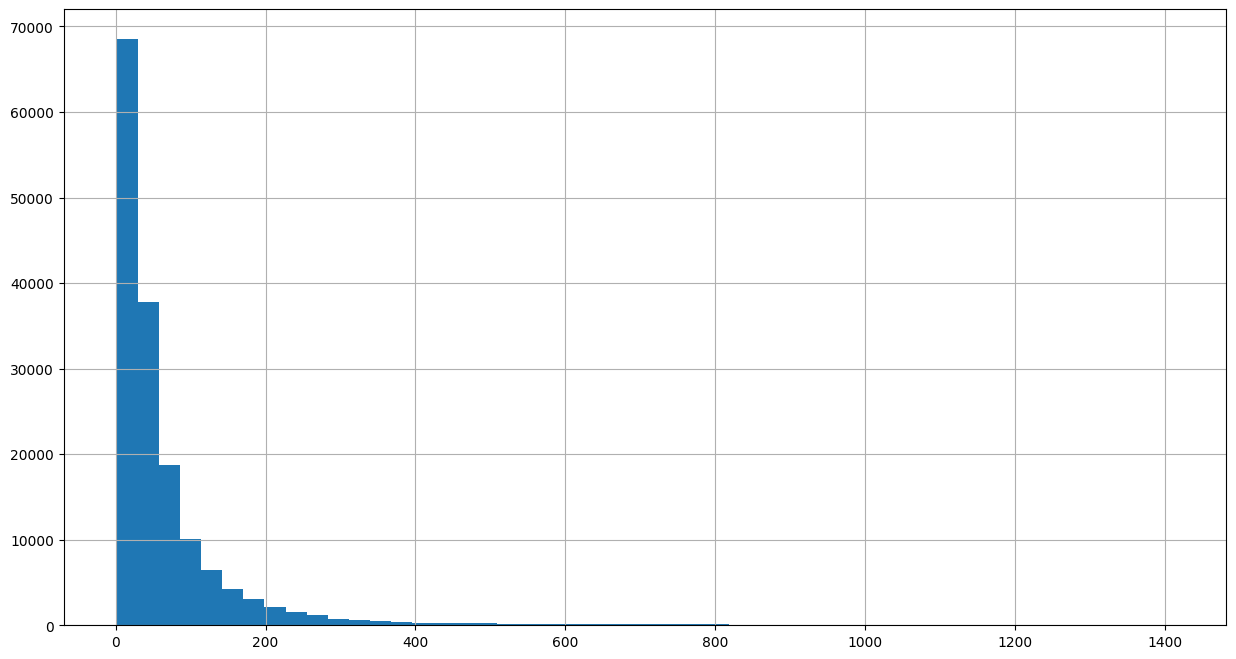

In [7]:
data['text'].apply(lambda x: len(x.split())).hist(figsize=(15, 8), bins=50)

In [8]:
(data['text'].apply(lambda x: len(x.split())) > 512).sum() / data.shape[0]

0.012360947191321598

Not so many. Only about 1% of coments won't fit in model completely. We can also suppose that it will be possible to detect toxic text only by a part of text.

In order to optimize the computational complexity, we will take not the entire dataset, but only a part of the data.

In [9]:
data = data.sample(40000, random_state=RS)

In [10]:
data.shape

(40000, 2)

## Tokenization

Tokenizing texts of comments

In [11]:
tokenizer = ppb.AutoTokenizer.from_pretrained("unitary/toxic-bert")

In [12]:
MAX_LENGTH = 512
# Tokenizing data
data_tokenized = data["text"].apply(
    lambda x: tokenizer.encode(
        x,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )
)

# Type conversion
data_padded = np.array([i for i in data_tokenized.values])

# Creating attention mask
attention_mask = np.where(data_padded != 0, 1, 0)

print(f"Tokenized (padded) data dimensions: {data_padded.shape}")
print(f"Attention mask dimensions: {attention_mask.shape}")

Tokenized (padded) data dimensions: (40000, 512)
Attention mask dimensions: (40000, 512)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

# Printing details of GPU device
if device.type == "cuda":
    gpu_device_name = torch.cuda.get_device_name(0)
    gpu_memory_alloc_GB = torch.cuda.memory_allocated(0) / 1024**3
    gpu_memory_cached_GB = torch.cuda.memory_reserved(0) / 1024**3

    print(f"Device name: {gpu_device_name}")
    print(f"Memory allocated: {np.round(gpu_memory_alloc_GB, 1)} GB")
    print(f"Memory cached: {np.round(gpu_memory_cached_GB, 1)} GB")

Using device: cuda:0
Device name: Tesla T4
Memory allocated: 0.0 GB
Memory cached: 0.0 GB


## Embeddings

Creating the embeddings.

In [14]:
model = ppb.AutoModel.from_pretrained("unitary/toxic-bert").to(device)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(data_padded.shape[0] // batch_size)):
    batch = torch.LongTensor(data_padded[batch_size * i : batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.LongTensor(
        attention_mask[batch_size * i : batch_size * (i + 1)]
    ).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy().astype('float16'))

  0%|          | 0/400 [00:00<?, ?it/s]

In [16]:
X = np.concatenate(embeddings)
y = data['toxic']
print(X.shape)
print(y.shape)

(40000, 768)
(40000,)


## Data splitting

Splitting the data in a ratio of 1 to 3

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS, stratify=y)

## Training the model

Now training the model with hyperparameter tuning on gridsearch with cross validation.

In [18]:
params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [19]:
gs = GridSearchCV(LogisticRegression(max_iter=5000), params, cv=5, scoring='f1')

In [20]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, scoring='f1')

In [21]:
gs.best_params_

{'C': 1}

In [22]:
gs.best_score_

0.947493963968846

Pretty good score.

## Testing the model

In [23]:
preds = gs.best_estimator_.predict(X_test)

In [24]:
f1_score(y_test, preds)

0.9393191909225456

The result on test split is slightly lower

## Exploration

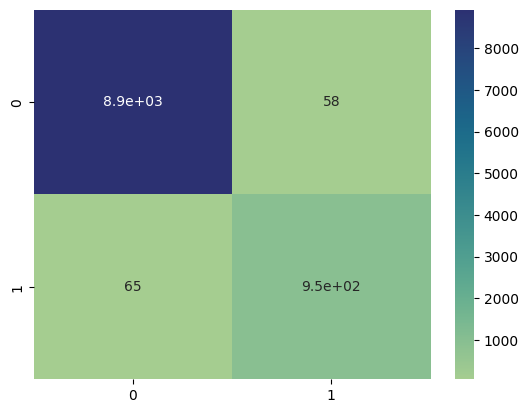

In [25]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True, cmap="crest");

The results are good. Out of 10,000 comments, only 65 of them marked as toxic were misinterpreted as non-toxic and 58 marked as non-toxic were classified as toxic. Now let's look at the text of those comments in which the model made mistakes.

In [26]:
result = pd.concat([y_test, pd.Series(preds, index=y_test.index)], axis=1)
result.columns = ['true', 'preds']
errors = result[result['true'] != result['preds']].index

Showing the text of first 20 comments

In [27]:
for line in errors[:20]:
    print(data.loc[line]['text'])
    print('TOXIC' if data.loc[line]['toxic'] else 'NON TOXIC')
    print('-' * 20)

What makes you think that I care about anything such an obviously unhinged person has to say about ducks or expressos or anything else? Step away from the computer, stop masturbating, and get some help. 193.109.199.35
NON TOXIC
--------------------
A classic BWilkins block, with all the familiar traits to experienced observers - brevity, arrogance and ultimately, ineffectiveness. In true BWilkins style though, someone else has to take his nonsense blocks to their inevitable conclusion . So take your bow Reaper Eternal, there's a good lad.

So here goes, BWilkins presumably blocked me because he thought I was about to OUT someone, yet in his incompetence failed to lock this page, so.....drum roll......User:Mo ainm used to be User:BigDunc, the account that 'retired' and never went back to editting the same articles, pulling the same stunts, or so the public record would have you believe.

Yes, that's the super secret information that the esteemed *arbitrator* Elen of the Roads thinks sho

If we look carefully at the texts of the comments, we can notice in most cases there were markup errors. Or the toxicity of a particular comment is difficult to assess out of context.

## Conclusion

The data contains 159292 lines of text messages. The ratio of classes in the data is approximately 1:9. No gaps or duplicates found. In order to optimize computing resources for the study of the pre-trained model based on Bert, it was decided to use only a part of the data (40'000 lines).
About 1% of all data was longer than the number of tokens that the model can accept as input. This is a small amount. In addition, we assume that the toxicity of most texts can probably be determined by the first 5 hundred tokens.

The pretrained 'unitary/toxic-bert' model was used.
First, the texts were tokenized by the tokenizer built into the model, then they were converted into embeddings, that is, a vector representation. After that, for classification, we used the usual linear regression on the obtained embeddings.

Further, the data were divided into training and test sets. We carried out the selection of hyperparameters on Gridsearch with cross-validation. We got a result on the F1 score of almost 0.95. Next, the model was tested on a test set. On it, the model showed the result F1 Score 0.94.

Out of 10000 comments, the model was wrong by about 100. When reviewing these comments, it turned out that many of them had markup errors. As well as difficulties in classifying in the absence of context.